# Attempting to measure the accuracy of volatility indexs
This notebook will look at how to quantify the effectiveness of a calculated index for any point in time. As these indexs are forward looking the performance of a security over the year following the date of observation will be taken.

In [51]:
%load_ext autoreload
%autoreload 2

import metrics_calc
from vix_calc_class import vix_calc
from vix_alternative import vix_alternative
import random

import sqlite3
import pandas as pd
pd.set_option('display.precision', 2)

import seaborn as sns
from datetime import datetime, timedelta

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
DT = '2022-01-07'
d = datetime.strptime(DT, '%Y-%m-%d')

V = vix_alternative()
data, vix = metrics_calc.observe_vix_acc(DT, V)
data.head(3)

,open,close,date_of,date_of_close,annual_,vix_t,price_up,price_down,change_ytd
0,476.30,466.09,2022-01-03,2022-01-07,0.00,0.00,466.09,466.09,0.00
1,462.70,464.72,2022-01-10,2022-01-14,0.02,3.79,483.78,448.40,0.29
2,459.74,437.98,2022-01-17,2022-01-21,0.04,5.37,491.10,441.08,6.03


# Aggregate Metrics
This Section will employ the metrics we developed in measure effect over a large period of time.

In [92]:

def run_aggs(vix_method, startdt='2021-01-08', num_weeks=52, userandom=False, seed=101):

    startdate = datetime.strptime(startdt, '%Y-%m-%d').date()
    # enddate = startdate + timedelta(weeks=num_weeks)
    
    all_data = {}
    metric_data = []
    if userandom:
        series = metrics_calc.sample_random_dates(num_weeks, seed=seed)
    else:
        series = [(startdate + timedelta(weeks=p)).strftime('%Y-%m-%d') for p in range(num_weeks)]
        
    for dt in series:
        mets = {}
        # dt = startdate + timedelta(weeks=p)
        mets['date'] = dt
        # print(dt)
        data, vix = metrics_calc.observe_vix_acc(DT=dt, vix_method=vix_method)
        mets['vix'] = vix

        mets.update(metrics_calc.aggregate_metrics.agg_metrics(data))

        metric_data.append(mets)
        all_data[dt] = data
    return metric_data, all_data


## Measure Classic VIX

In [93]:
# startdt = '2021-01-08'
num_weeks=180
V = vix_calc()
metric_data, all_data = run_aggs(V, startdt, num_weeks, userandom=True)
# data, vix = metrics_calc.observe_vix_acc(DT, vix_method=V)
# vix

mm = pd.DataFrame.from_dict(metric_data)
mm = mm.dropna()
mm.head(3)

,date,vix,accuracy,stddev,auc,aoc,yearopen,yearclose,vixtotal
0,2017-01-20,10.66,0.34,12.83,14.06,-122.56,226.74,280.41,374.07
1,2021-11-12,16.49,0.60,33.95,101.53,-79.92,467.27,398.51,578.60
2,2016-04-15,13.66,0.89,10.12,171.71,-6.24,207.78,232.51,479.36


In [94]:
metrics_calc.aggregate_metrics.curve_areas(mm, verbose=True)

Mean Area Under Curve: 192.42119246610258
Mean Area Over Curve: -46.774228258653665
Mean Area Between Curves: 145.64696420744886
Ratio : 0.229441505999334


In [95]:
mm[["vix", 'accuracy', 'stddev', 'vixtotal', 'auc', 'aoc', 'abc', 'rd']].describe()

,vix,accuracy,stddev,vixtotal,auc,aoc,abc,rd
count,161.00,161.00,161.00,161.00,161.00,161.00,161.00,161.00
mean,16.89,0.71,18.21,592.61,192.42,-46.77,145.65,0.23
std,6.72,0.22,9.52,235.64,165.54,46.00,198.10,0.30
min,8.73,0.21,7.19,306.35,9.46,-234.09,-211.74,-0.42
25%,12.22,0.53,10.92,428.80,68.91,-78.60,-7.38,-0.02
50%,14.84,0.75,13.93,520.62,153.00,-35.75,118.03,0.17
75%,20.46,0.91,25.86,717.96,264.26,-4.57,256.52,0.50
max,38.56,1.00,39.37,1353.23,815.03,0.00,813.97,0.79


### Measure Alternative VIX

In [35]:
# startdt = '2021-01-08'
num_weeks=180
V = vix_alternative()
metric_data, all_data = run_aggs(V, startdt, num_weeks, userandom=True)
# data, vix = metrics_calc.observe_vix_acc(DT, vix_method=V)
# vix

mm = pd.DataFrame.from_dict(metric_data)
mm = mm.dropna()
mm.head(3)

,date,vix,accuracy,stddev,auc,aoc,yearopen,yearclose,vixtotal
0,2021-01-08,33.05,1.0,29.20,500.64,0.0,381.26,466.09,1159.61
1,2021-01-15,27.53,1.0,28.88,203.15,0.0,375.70,464.72,966.12
2,2021-01-22,31.17,1.0,27.90,423.08,0.0,382.88,437.98,1093.69


In [36]:
metrics_calc.aggregate_metrics.curve_areas(mm, verbose=True)

Mean Area Under Curve: 536.0927184618001
Mean Area Over Curve: -1.1480262992587678
Mean Area Between Curves: 534.9446921625415
Ratio : 0.5498475907137397


In [37]:
mm[["vix", 'accuracy', 'stddev', 'auc', 'aoc', 'abc', 'rd']].describe()

,vix,accuracy,stddev,auc,aoc,abc,rd
count,50.00,50.00,50.00,50.00,50.00,50.00,50.00
mean,27.81,0.99,25.91,536.09,-1.15,534.94,0.55
std,6.47,0.05,5.61,185.54,4.53,187.61,0.15
min,19.64,0.72,16.42,159.73,-28.24,131.49,0.15
25%,22.68,1.00,21.29,425.35,0.00,425.35,0.43
50%,25.88,1.00,27.10,521.04,0.00,521.04,0.60
75%,31.30,1.00,29.79,644.24,0.00,644.24,0.66
max,46.33,1.00,34.51,1068.86,0.00,1068.86,0.74


# Instant metrics

## A look at implied volatilty as prescribed by the vix over a period of time

In [11]:
data_keys = list(all_data.keys())

VIX for 2021-01-08: 33.046313729487494


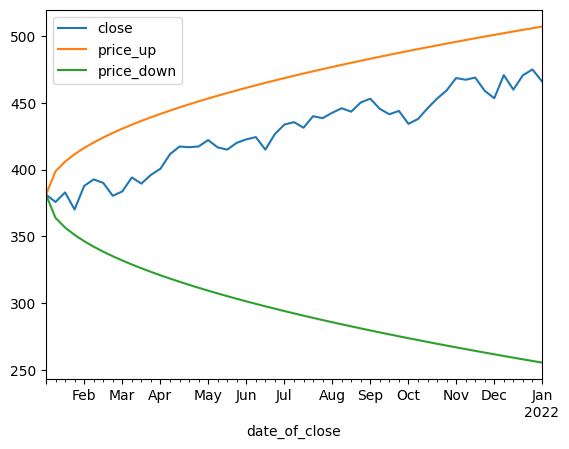

In [12]:
DT = data_keys[0]
data, VIX = metrics_calc.observe_vix_acc(DT, V)
print(f"VIX for {DT}:", VIX)
data.plot(x='date_of_close', y=['close', 'price_up', 'price_down']);

## A look at the absolute change in the SPY (to date), and the prescribed volatility bound

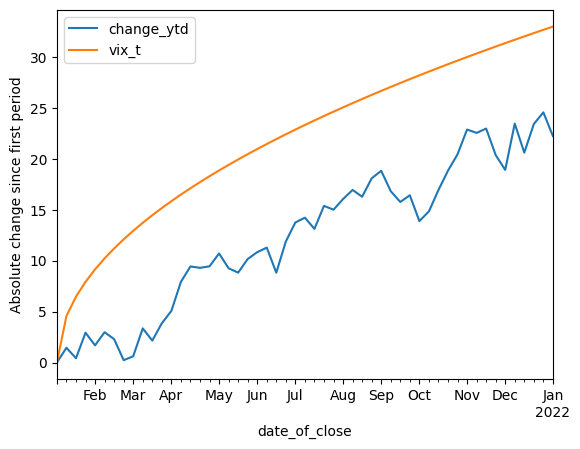

In [13]:
data['change_ytd'] = abs(data.close / data.close.iloc[0] - 1) * 100
ax = data.plot(x='date_of_close', y=['change_ytd', 'vix_t'])
ax.set_ylabel('Absolute change since first period');

## 3 ways of measuring effectiveness for a individual period
1. Count how frequently the SPY leaves the vix bounds
3. Compare Index to the standard deviation of the stocks proven performance
2. Take the difference between the area under the curve for both indexs.

### Simple Accuracy

In [14]:
df = data[['close', 'date_of_close', 'vix_t', 'change_ytd']].copy()

# within, exceeded = df.bounded.value_counts().loc[True], df.bounded.value_counts().loc[False]
within, exceeded = metrics_calc.calc_accuracy(df, real_col='change_ytd')
print('Within Bound:\t', within)
print('Exceeded bound:\t', exceeded)
print('Accuracy: ', round(within/(within+exceeded)*100, 2))

Within Bound:	 53
Exceeded bound:	 0
Accuracy:  100.0


### Standard Deviation
Note: As the standard deviation is an annualised value, for any given point, the difference between the VIX and the STD for the following year can be compared.

In [15]:
print('Standard Deviation:\t\t', df.close.std())
print('Relative Standard Deviation:\t', df.close.std() / df.close.mean() * 100)

Standard Deviation:		 29.20094944725582
Relative Standard Deviation:	 6.82268783252494


### Analysing Curve Areas

In [16]:
data['vix_t2'] = data.annual_.apply(lambda x: metrics_calc.get_period_volatility(2*VIX, x))

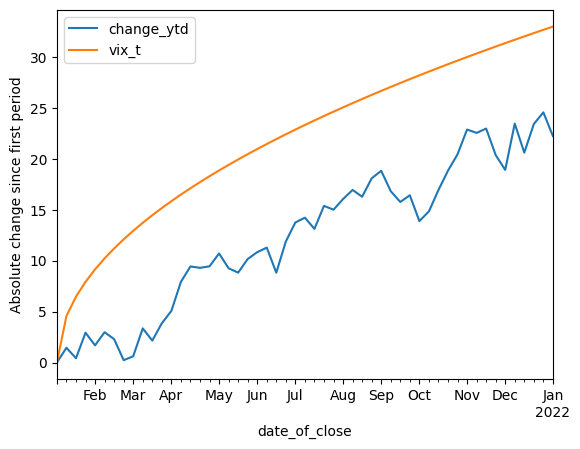

In [18]:
ax = data.plot(x='date_of_close', y=['change_ytd', 'vix_t'])
ax.set_ylabel('Absolute change since first period');

In [19]:
metrics_calc.aggregate_metrics.agg_metrics(data)

{'accuracy': 1.0,
 'stddev': 29.20094944725582,
 'auc': 500.6378399884466,
 'aoc': 0.0,
 'yearopen': 381.26,
 'yearclose': 466.09,
 'vixtotal': 1159.6107193883313}

In [20]:
curve_aoc, curve_auc = metrics_calc.calc_auc_aoc(data, curveA='change_ytd', curveB='vix_t')
print(f"Area under Curve {curve_auc}\nArea Over Curve\t {curve_aoc}")

Area under Curve 0.0
Area Over Curve	 500.6378399884466


### Analysing MAE MSE

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn import metrics

In [23]:
test_data = data.iloc[1:].copy()
chg_pct, vix_t_pct = test_data.change_ytd/100, test_data.vix_t/100
mean_squared_error(chg_pct, vix_t_pct)

0.009713536279515073

In [24]:
# chg_pct, vix_t_pct = data.change_ytd/100, data.vix_t/100
mean_absolute_error(test_data.change_ytd, test_data.vix_t)

9.62765076900859

In [25]:
test_data['std'] = test_data.change_ytd / test_data.vix_t

In [26]:
test_data['std'].mean()

0.5117275763261407